# **Phase 3:**

# Read Dataset:

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D



df = pd.read_csv("Dataset/Preprocessed_data.csv")
df

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,SlowHealingSores,TinglingHandsFeet,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis
0,Older_Adults,0,1,2,1,Obese,1,0.224975,0.244179,0.489903,...,0,1,73.765109,0,0,0,0.445156,0.448528,0.721628,1
1,Older_Adults,1,0,1,2,Obese,0,0.078918,0.830564,0.894218,...,0,0,91.445753,0,0,1,0.845172,0.596122,0.502794,1
2,Seniors,1,0,1,3,Normal,0,0.058832,0.610553,0.772336,...,0,0,54.485744,0,0,0,0.674977,0.895280,0.703974,0
3,Young_Adults,1,1,1,2,Obese,1,0.085705,0.865020,0.480422,...,0,0,77.866758,0,0,1,0.351638,0.312195,0.472087,0
4,Young_Adults,1,0,1,3,Underweight,0,0.773263,0.463001,0.253243,...,0,0,37.731808,0,0,0,0.303936,0.697809,0.789337,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,Older_Adults,0,0,2,2,Normal,0,0.547393,0.321683,0.833915,...,0,1,88.122729,0,0,1,0.788400,0.384736,0.881119,0
1875,Seniors,1,0,2,2,Overweight,0,0.803538,0.711050,0.303456,...,1,0,77.128599,0,0,1,0.105333,0.521637,0.091619,1
1876,Older_Adults,1,0,0,2,Obese,0,0.243267,0.988720,0.265670,...,0,0,13.148221,0,0,0,0.137584,0.337513,0.301933,1
1877,Older_Adults,0,1,2,0,Obese,0,0.318175,0.475083,0.873707,...,0,0,54.370980,0,0,0,0.282418,0.000387,0.491780,1


# Clustering:


In [62]:
# STEP 1: PREPARE DATA FOR K-MEANS (CONVERT CATEGORICAL TO NUMERICAL)

# Create a copy of the dataframe for clustering
df_cluster = df.copy()

# Convert categorical columns to numerical using Label Encoding
categorical_cols = ['Age', 'BMI']  # These were discretized in Phase 2

label_encoders = {}
for col in categorical_cols:
    if col in df_cluster.columns and df_cluster[col].dtype == 'object':
        le = LabelEncoder()
        df_cluster[col] = le.fit_transform(df_cluster[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {dict(enumerate(le.classes_))}")

print(f"\nData types after encoding:")
print(df_cluster.dtypes.value_counts())

Encoded Age: {0: 'Older_Adults', 1: 'Seniors', 2: 'Young_Adults'}
Encoded BMI: {0: 'Normal', 1: 'Obese', 2: 'Overweight', 3: 'Underweight'}

Data types after encoding:
int64      25
float64    19
Name: count, dtype: int64


In [63]:
# Extract features(X) "excluding the target variable"
X = df.drop('Diagnosis', axis=1)
# Scale the features (X)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)
print("\nScaled DataFrame:")
print(scaled_df.head())


Scaled DataFrame:
     Gender  Ethnicity  SocioeconomicStatus  EducationLevel   Smoking  \
0 -0.975292   0.233251             1.318079       -0.789795  1.597493   
1  1.025334  -0.721604             0.010439        0.339600 -0.625981   
2  1.025334  -0.721604             0.010439        1.468995 -0.625981   
3  1.025334   0.233251             0.010439        0.339600  1.597493   
4  1.025334  -0.721604             0.010439        1.468995 -0.625981   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  \
0           -0.946653         -0.965393     0.001057     -1.718582   
1           -1.440586          1.085505     1.411289      0.281561   
2           -1.508511          0.316010     0.986171      0.397372   
3           -1.417635          1.206012    -0.032011     -0.424972   
4            0.907540         -0.200055    -0.824400      1.590389   

   FamilyHistoryDiabetes  ...  OccupationalExposureChemicals  WaterQuality  \
0               1.787231  ...              

In [64]:
# Evaluate K-means with different values of K
k_values = range(2, 11)  # Test K from 2 to 10 that’s mean more than 3 times
silhouette_scores = []
wss_values = []  # To hold Within-cluster Sum of Squares
# Calculate silhouette score and Calinski-Harabasz score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    silhouette_avg = silhouette_score(scaled_df, kmeans.labels_)
    print(f"Sillhoutte Score for K={k}: {silhouette_avg:.2f}")


    silhouette_scores.append(silhouette_avg)
    wss_values.append(kmeans.inertia_)

Sillhoutte Score for K=2: 0.06
Sillhoutte Score for K=3: 0.03
Sillhoutte Score for K=4: 0.03
Sillhoutte Score for K=5: 0.03
Sillhoutte Score for K=6: 0.03
Sillhoutte Score for K=7: 0.02
Sillhoutte Score for K=8: 0.02
Sillhoutte Score for K=9: 0.02
Sillhoutte Score for K=10: 0.02


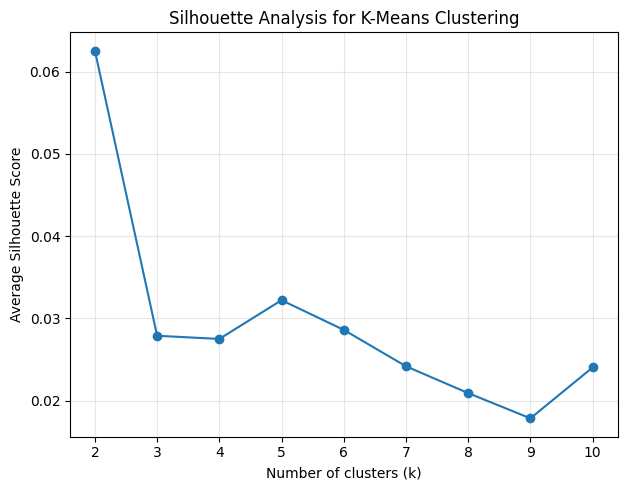

In [65]:
# Plot the results
plt.figure(figsize=(12, 5))

# Silhouette Score Plot
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Analysis for K-Means Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True, alpha=0.3)  

plt.tight_layout()
plt.show()

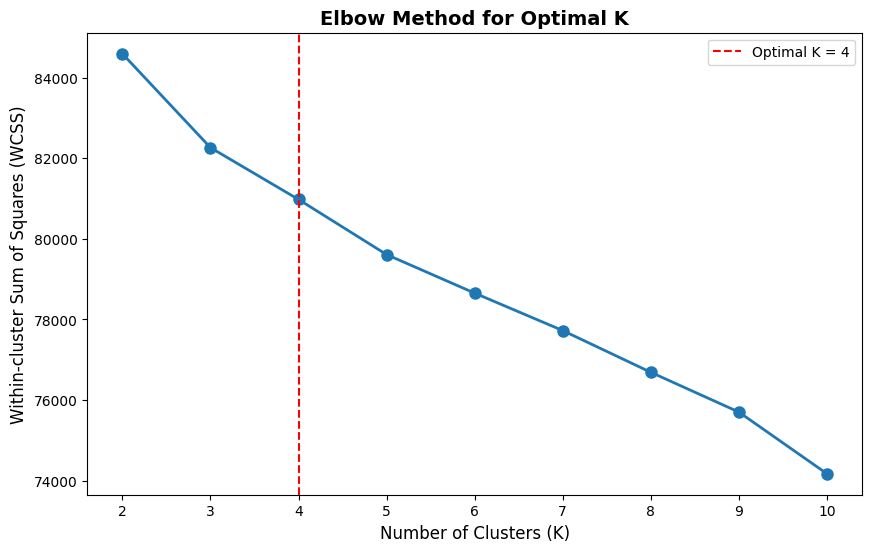

Optimal K based on Elbow Method: 4


In [66]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-cluster Sum of Squares (WCSS)', fontsize=12)
# Automatically find the elbow point instead of hardcoding k=4
# Find the point where the reduction in WCSS slows down significantly
wss_reductions = [wss_values[i-1] - wss_values[i] for i in range(1, len(wss_values))]
reduction_ratios = [wss_reductions[i] / wss_reductions[i-1] for i in range(1, len(wss_reductions))]

if reduction_ratios:
    optimal_k = k_values[np.argmin(reduction_ratios) + 2]  # +2 because we start from index 2
else:
    optimal_k = 3  # Default fallback

plt.axvline(x=optimal_k, linestyle='--', color='red', label=f'Optimal K = {optimal_k}')
plt.legend()
plt.show()

print(f"Optimal K based on Elbow Method: {optimal_k}")

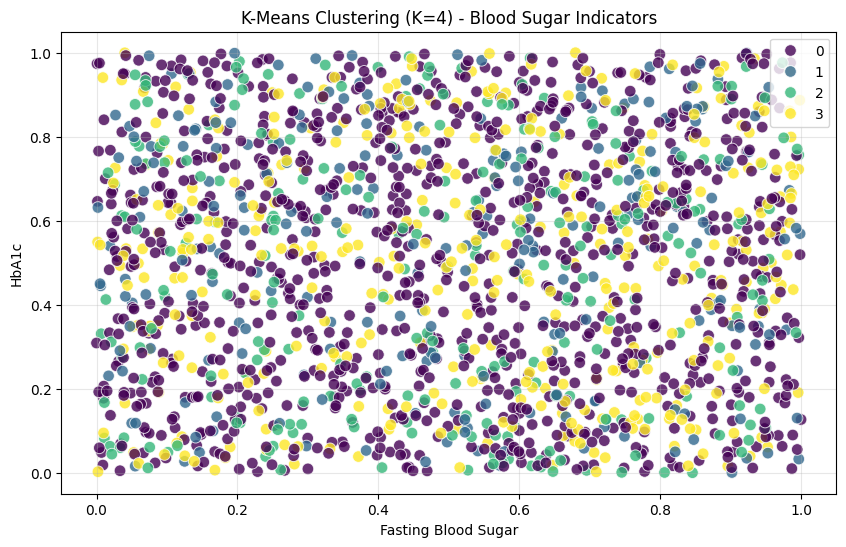

In [77]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(scaled_df)
df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x='FastingBloodSugar', y='HbA1c', hue='Cluster', data=df, 
               palette='viridis', alpha=0.8, s=70)
plt.title(f'K-Means Clustering (K={optimal_k}) - Blood Sugar Indicators')
plt.xlabel('Fasting Blood Sugar')
plt.ylabel('HbA1c')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

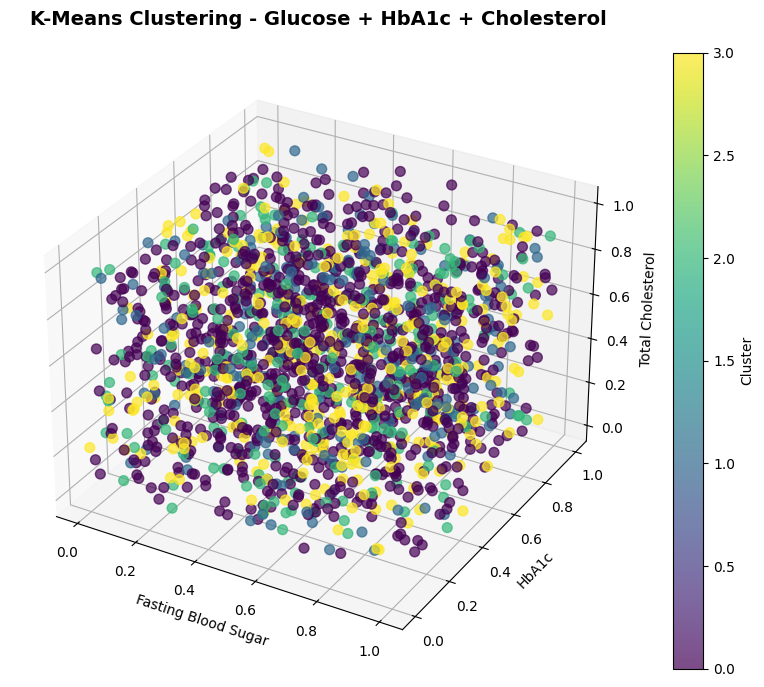

In [90]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use features that are definitely numerical
scatter = ax.scatter(df['FastingBloodSugar'],  # Definitely float (0-1)
                     df['HbA1c'],              # Definitely float (0-1)  
                     df['CholesterolTotal'],   # Definitely float (0-1)
                     c=df['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7,
                     s=50)

ax.set_title("K-Means Clustering - Glucose + HbA1c + Cholesterol", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Fasting Blood Sugar')
ax.set_ylabel('HbA1c')
ax.set_zlabel('Total Cholesterol')

plt.colorbar(scatter, label='Cluster')
plt.show()

In [91]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

np.random.seed(8953)

# Perform K-means clustering for K=2
kmeans = KMeans(n_clusters=2, random_state=8953, n_init='auto')  # Set n_init explicitly and init='auto'
kmeans_result = kmeans.fit(scaled_df)

# Print the clustering result
print("Cluster Centers:")
print(kmeans_result.cluster_centers_)
print("\nCluster Labels:")
print(kmeans_result.labels_)

Cluster Centers:
[[ 1.62078034e-02  1.45175992e-02  5.65230806e-02 -7.33507268e-02
   1.06968715e-02  1.96428473e-02 -5.22127668e-02 -1.16679681e-02
   4.16936115e-02  1.42417543e-02  6.01470567e-03 -2.44710395e-02
   4.37915071e-02  2.53158440e-03  4.15502833e-02 -2.03622025e-02
   2.43239919e-03 -2.97934426e-02  2.74169354e-02  3.26343215e-02
  -1.88934620e-02 -1.07266109e-02 -6.72108088e-02  2.33828838e-02
   3.04768967e-02 -1.96972187e-02  1.29443698e-02  2.96571298e-02
  -1.51043824e-02 -2.66016639e-02 -3.88286755e-02  5.45827398e-01
  -2.63535644e-02 -5.25282506e-02  2.63311909e-02  1.30910918e-02
  -5.69978270e-02 -1.14947467e-02  4.09198754e-02 -1.88948247e-02
  -7.52320627e-02 -7.59172103e-01  1.56729492e+00 -3.19086946e-02
  -3.54366877e-02  1.51259299e-02]
 [-5.16374929e-03 -4.62525617e-03 -1.80080551e-02  2.33692842e-02
  -3.40798573e-03 -6.25814224e-03  1.66348043e-02  3.71737370e-03
  -1.32834383e-02 -4.53737294e-03 -1.91626412e-03  7.79638733e-03
  -1.39518205e-02 -8.065

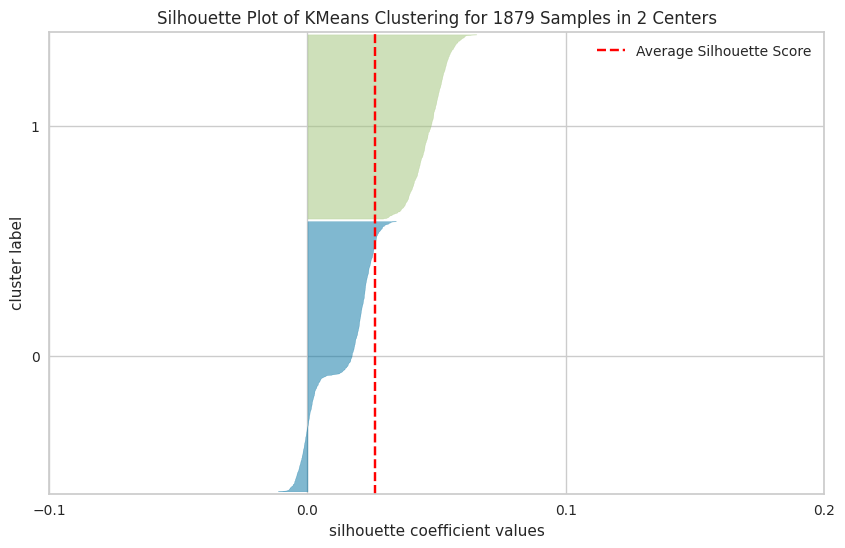

Silhouette Score: 0.0263


In [105]:
# =============================================================================
# YELLOWBRICK SILHOUETTE PLOT
# =============================================================================

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

# Create the silhouette plot for K=2
fig, ax = plt.subplots(figsize=(10, 6))

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
visualizer = SilhouetteVisualizer(kmeans, ax=ax, colors='yellowbrick')
visualizer.fit(scaled_df)
visualizer.finalize()
visualizer.show()
plt.show()

# Show the actual score
silhouette_avg = silhouette_score(scaled_df, visualizer.estimator.labels_)
print(f"Silhouette Score: {silhouette_avg:.4f}")